## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.tools.eval_measures import rmse
import matplotlib.lines as mlines
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import t
from matplotlib.collections import LineCollection

## Load Data

In [2]:
path = '/Users/alexaterrazas/Desktop/Lake Transfer Function Manuscript/'
df = pd.read_csv(path + 'ERA5_LakeTemp.csv')

df

,Hylak_id,center_long,center_lat,Lake_name,Country,Continent,Lake_type,Lake_area,Depth_avg,Elevation,...,nearest_u10_12,tas_ann_avg,tas_ao_avg,tas_amj_avg,tas_jja_avg,tas_warmest_month,tcc_ann_avg,rh_ann_avg,ssr_ann_avg,u10_ann_avg
0,2,-120.798314,66.045499,Great Bear,Canada,North America,1,30450.640630,72.199997,145,...,-0.507173,-6.916099,2.537903,-2.924408,6.540436,10.075806,69.828000,83.100494,6855008.5,-0.772132
1,3,-114.122174,61.686169,Great Slave,Canada,North America,1,26734.289060,59.099998,148,...,0.016849,-4.109226,5.273084,-0.516378,9.650258,13.731232,68.507324,82.211360,8087732.0,-0.752795
2,5,-86.740535,47.404209,Superior,United States of America,North America,1,81843.921880,146.699997,179,...,2.475010,3.403867,8.581979,3.673055,11.211670,14.940918,70.047005,82.009660,11453339.0,1.421462
3,6,-86.985025,42.800746,Michigan,United States of America,North America,1,57726.839840,84.199997,175,...,3.009383,8.354764,14.112823,8.495789,18.356333,21.555786,65.781070,79.898430,13610045.0,1.222900
4,8,-82.413357,44.756304,Huron,United States of America,North America,1,59399.300780,59.799999,175,...,3.486718,6.322446,11.789232,6.097422,15.698009,19.275665,67.142430,80.979000,12723721.0,1.852352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,16401,124.453670,-27.964728,NaN,Australia,Oceania,1,98.800003,3.500000,350,...,-2.138058,21.850060,26.324127,26.252329,28.709137,29.339020,30.269270,36.241375,17317706.0,-1.394071
1391,16504,136.087104,-30.844098,NaN,Australia,Oceania,1,84.529999,9.500000,117,...,-0.467818,19.793040,24.039598,23.623413,26.800873,27.477844,32.712025,47.085240,17531248.0,-0.143916
1392,16566,142.228826,-32.478639,NaN,Australia,Oceania,1,86.879997,5.400000,60,...,0.069036,19.291960,23.587894,23.096466,26.781738,27.840820,33.717556,49.851850,17753004.0,0.328720
1393,16567,152.431391,-32.418694,NaN,Australia,Oceania,1,97.269997,23.000000,1,...,-1.449389,18.569963,21.224056,20.520334,22.761270,23.776672,44.109386,72.814224,14977280.0,0.029541


## Hren and Sheldon, 2012

In [3]:
# Define the function with condition
def hs_annual(x):
    return (-0.0318) * np.power(x, 2) + (2.195 * x) - 12.607

def plot_hs_ann(ax):
    gray = '#4CBB17'
    red = '#c1272d'

    x_annual = df['lswt_ann_avg']
    y_actual = df['tas_ann_avg']

    # create a range of x-values to make predictions on, within the valid range
    x_pred = np.linspace(5, 30, 100)
    
    y_pred = hs_annual(x_annual)
    
    r2 = r2_score(y_actual, y_pred)
    rmse_val = np.sqrt(mean_squared_error(y_actual, y_pred))

    # use the function to make predictions
    y_pred = hs_annual(x_pred)
   
    # calculate the standard deviation of the residuals
    residuals = y_actual - hs_annual(x_annual)
    std_resid = np.sqrt(np.sum(np.power(residuals, 2)) / (len(x_annual) - 2))

    # calculate the t-value for the desired confidence level
    t_value = t.ppf(0.975, len(x_annual) - 2)

    # calculate the confidence interval
    mean_x = np.mean(x_annual)
    var_x = np.var(x_annual, ddof=1)
    conf_int = t_value * std_resid * np.sqrt(1 + 1/len(x_annual) + np.power((x_pred - mean_x), 2) / ((len(x_annual) - 1) * var_x))

    # calculate the prediction interval
    pred_int = t_value * std_resid * np.sqrt(1 + 1/len(x_annual) + np.power((x_pred - mean_x), 2) / ((len(x_annual) - 1) * var_x)) * np.sqrt(1 + 1/len(x_annual))

    # plot the function, the predicted values, the confidence interval, and the prediction interval
    ax.plot(x_pred, y_pred, color = 'k', label='Function', zorder = 10, linewidth = 4)
    ax.fill_between(x_pred, y_pred - pred_int, y_pred + pred_int, alpha=0.15, label='95% Prediction Interval', color = plt.cm.tab10(7))
    
    # Plot the lower prediction interval bound as a dashed line
    ax.plot(x_pred, y_pred - pred_int, linestyle='--', label='_nolegend_', color = 'k')

    # Plot the upper prediction interval bound as a dashed line
    ax.plot(x_pred, y_pred + pred_int, linestyle='--', label='_nolegend_', color = 'k')

    return ax, r2, rmse_val


In [4]:
# Define the function with condition
def hs_AO(x):
    return (-0.0146) * np.power(x, 2) + (1.753 * x) - 16.079

def plot_hs_AO(ax):
    gray = '#808080'
    red = '#c1272d'

    x_ao = df['lswt_ao_avg']
    y_actual = df['tas_ann_avg']

    # create a range of x-values to make predictions on, within the valid range
    x_pred = np.linspace(6, 31, 100)

    y_pred = hs_AO(x_ao)
    
    r2 = r2_score(y_actual, y_pred)
    
    rmse_val = np.sqrt(mean_squared_error(y_actual, y_pred))

    # use the function to make predictions
    y_pred = hs_AO(x_pred)

    # calculate the standard deviation of the residuals
    residuals = y_actual - hs_AO(x_ao)
    std_resid = np.sqrt(np.sum(np.power(residuals, 2)) / (len(x_ao) - 2))

    # calculate the t-value for the desired confidence level
    t_value = t.ppf(0.975, len(x_ao) - 2)

    # calculate the confidence interval
    mean_x = np.mean(x_ao)
    var_x = np.var(x_ao, ddof=1)
    conf_int = t_value * std_resid * np.sqrt(1 + 1/len(x_ao) + np.power((x_pred - mean_x), 2) / ((len(x_ao) - 1) * var_x))

    # calculate the prediction interval
    pred_int = t_value * std_resid * np.sqrt(1 + 1/len(x_ao) + np.power((x_pred - mean_x), 2) / ((len(x_ao) - 1) * var_x)) * np.sqrt(1 + 1/len(x_ao))

    # plot the function, the predicted values, the confidence interval, and the prediction interval
    ax.plot(x_pred, y_pred, color = 'k', label='Function', zorder = 10, linewidth = 4)
    ax.fill_between(x_pred, y_pred - pred_int, y_pred + pred_int, alpha=0.15, label='95% Prediction Interval', color = plt.cm.tab10(7))
    
    # Plot the lower prediction interval bound as a dashed line
    ax.plot(x_pred, y_pred - pred_int, linestyle='--', label='_nolegend_', color = 'k')

    # Plot the upper prediction interval bound as a dashed line
    ax.plot(x_pred, y_pred + pred_int, linestyle='--', label='_nolegend_', color = 'k')

    return ax, r2, rmse_val


In [5]:
def hs_AMJ(x):
    return (-0.0097) * np.power(x, 2) + (1.379 * x) - 8.227

def plot_hs_AMJ(ax):
    gray = '#808080'
    red = '#c1272d'
    orange = '#F28C28'

    x_amj = df['lswt_amj_avg']
    y_actual = df['tas_ann_avg']

    y_pred = hs_AMJ(x_amj)
    
    r2 = r2_score(y_actual, y_pred)
    
    rmse_val = np.sqrt(mean_squared_error(y_actual, y_pred))

    # Create a range of x-values to make predictions on, within the valid range
    x_pred = np.linspace(2, 29, 100)

    # Use the function to make predictions
    y_pred = hs_AMJ(x_pred)
    
    # Calculate the standard deviation of the residuals
    residuals = y_actual - hs_AMJ(x_amj)
    std_resid = np.sqrt(np.sum(np.power(residuals, 2)) / (len(x_amj) - 2))

    # Calculate the t-value for the desired confidence level
    t_value = t.ppf(0.975, len(x_amj) - 2)

    # Calculate the confidence interval
    mean_x = np.mean(x_amj)
    var_x = np.var(x_amj, ddof=1)
    conf_int = t_value * std_resid * np.sqrt(1 + 1/len(x_amj) + np.power((x_pred - mean_x), 2) / ((len(x_amj) - 1) * var_x))

    # Calculate the prediction interval
    pred_int = t_value * std_resid * np.sqrt(1 + 1/len(x_amj) + np.power((x_pred - mean_x), 2) / ((len(x_amj) - 1) * var_x)) * np.sqrt(1 + 1/len(x_amj))

    # Plot the function, the predicted values, the confidence interval, and the prediction interval
    ax.plot(x_pred, y_pred, color = 'k', label='Function', zorder = 10, linewidth = 4)
    ax.fill_between(x_pred, y_pred - pred_int, y_pred + pred_int, alpha=0.2, label='95% Prediction Interval', color = plt.cm.tab10(7), zorder = 0)
    
    # Plot the lower prediction interval bound as a dashed line
    ax.plot(x_pred, y_pred - pred_int, linestyle='--', label='_nolegend_', color ='k')

    # Plot the upper prediction interval bound as a dashed line
    ax.plot(x_pred, y_pred + pred_int, linestyle='--', label='_nolegend_', color = 'k')

    return ax, r2, rmse_val


In [6]:
def hs_JJA(x):
    return (-0.0055) * np.power(x, 2) + (1.476 * x) - 18.915

def plot_hs_JJA(ax):
    gray = '#808080'
    red = '#c1272d'

    x_jja = df['lswt_jja_avg']
    y_actual = df['tas_ann_avg']

    y_pred = hs_JJA(x_jja)
    
    r2 = r2_score(y_actual, y_pred)

    rmse_val = np.sqrt(mean_squared_error(y_actual, y_pred))

    # Create a range of x-values to make predictions on, within the valid range
    x_pred = np.linspace(9, 34, 100)

    # Use the function to make predictions
    y_pred = hs_JJA(x_pred)
   
    # Calculate the standard deviation of the residuals
    residuals = y_actual - hs_JJA(x_jja)
    std_resid = np.sqrt(np.sum(np.power(residuals, 2)) / (len(x_jja) - 2))

    # Calculate the t-value for the desired confidence level
    t_value = t.ppf(0.975, len(x_jja) - 2)

    # Calculate the confidence interval
    mean_x = np.mean(x_jja)
    var_x = np.var(x_jja, ddof=1)
    conf_int = t_value * std_resid * np.sqrt(1 + 1/len(x_jja) + np.power((x_pred - mean_x), 2) / ((len(x_jja) - 1) * var_x))

    # Calculate the prediction interval
    pred_int = t_value * std_resid * np.sqrt(1 + 1/len(x_jja) + np.power((x_pred - mean_x), 2) / ((len(x_jja) - 1) * var_x)) * np.sqrt(1 + 1/len(x_jja))

    # Plot the function, the predicted values, the confidence interval, and the prediction interval
    ax.plot(x_pred, y_pred, color = 'k', label='Function', zorder = 10, linewidth = 4)
    ax.fill_between(x_pred, y_pred - pred_int, y_pred + pred_int, alpha=0.15, label='95% Prediction Interval', color = plt.cm.tab10(7))
    
    # Plot the lower prediction interval bound as a dashed line
    ax.plot(x_pred, y_pred - pred_int, linestyle='--', label='_nolegend_', color = 'k')

    # Plot the upper prediction interval bound as a dashed line
    ax.plot(x_pred, y_pred + pred_int, linestyle='--', label='_nolegend_', color = 'k')
    
    return ax, r2, rmse_val


In [7]:
def hs_Warmest(x):
    return (x/0.562) - (17.3/0.562)

def plot_hs_Warmest(ax):
    gray = '#808080'
    red = '#c1272d'

    x_Warmest = df['lswt_warmest_avg']
    y_actual = df['tas_ann_avg']

    y_pred = hs_Warmest(x_Warmest)
    
    r2 = r2_score(y_actual, y_pred)

    rmse_val = np.sqrt(mean_squared_error(y_actual, y_pred))

    # Create a range of x-values to make predictions on, within the valid range
    x_pred = np.linspace(12, 35, 100)

    # Use the function to make predictions
    y_pred = hs_Warmest(x_pred)
   
    # Calculate the standard deviation of the residuals
    residuals = y_actual - hs_Warmest(x_Warmest)
    std_resid = np.sqrt(np.sum(np.power(residuals, 2)) / (len(x_Warmest) - 2))

    # Calculate the t-value for the desired confidence level
    t_value = t.ppf(0.975, len(x_Warmest) - 2)

    # Calculate the confidence interval
    mean_x = np.mean(x_Warmest)
    var_x = np.var(x_Warmest, ddof=1)
    conf_int = t_value * std_resid * np.sqrt(1 + 1/len(x_Warmest) + np.power((x_pred - mean_x), 2) / ((len(x_Warmest) - 1) * var_x))

    # Calculate the prediction interval
    pred_int = t_value * std_resid * np.sqrt(1 + 1/len(x_Warmest) + np.power((x_pred - mean_x), 2) / ((len(x_Warmest) - 1) * var_x)) * np.sqrt(1 + 1/len(x_Warmest))

    # Plot the function, the predicted values, the confidence interval, and the prediction interval
    ax.plot(x_pred, y_pred, color = 'k', label='Function', zorder = 10, linewidth = 4)
    ax.fill_between(x_pred, y_pred - pred_int, y_pred + pred_int, alpha=0.15, label='95% Prediction Interval', color = plt.cm.tab10(7))
    
    # Plot the lower prediction interval bound as a dashed line
    ax.plot(x_pred, y_pred - pred_int, linestyle='--', label='_nolegend_', color = 'k')

    # Plot the upper prediction interval bound as a dashed line
    ax.plot(x_pred, y_pred + pred_int, linestyle='--', label='_nolegend_', color = 'k')
    
    return ax, r2, rmse_val

In [8]:
# def plot_hs_Warmest(ax):
#     # Ensure this function does not clear or reset the axes
#     x_Warmest = df['lswt_warmest_avg']
#     y_actual = df['tas_ann_avg']

#     y_pred = hs_Warmest(x_Warmest)
    
#     # Plot the function line
#     ax.plot(x_Warmest, y_pred, color = 'k', label='Function', zorder=10, linewidth=4)

#     # Plot the prediction interval
#     ax.fill_between(x_Warmest, y_pred - pred_int, y_pred + pred_int, alpha=0.15, color='gray', label='95% Prediction Interval')
    
#     return ax, r2, rmse_val


## Multiple Linear Regression: TF4

In [9]:
def plot_bestfit_TF4(ax, season, xlabel):
    
    #plotting font and tick label sizes
    plt.rcParams['font.family'] = 'Arial'
    ax.tick_params(axis='both', which='major', labelsize=11)

    #colors used
    blue = '#073980'
    red = '#EE7733'
    gray = '#696969'
       
    #fontsize
    fs1 = 20
    fs2 = 20
    

    ####################################
    
    df['Tw squared'] = np.power(df[season], 2)

    X = df[['Tw squared', season, 'abs_lat', 'elevation_km']]
    y = df['tas_ann_avg'] 
    X = sm.add_constant(X) 
    
    #MODEL
 
    model = sm.OLS(y, X).fit() 

    summary = model.summary()
    
  
    # statsmodel fitting
    st, data, ss2 = summary_table(model, alpha = 0.05)

    fittedvalues = data[:, 2]
    predict_mean_se = data[:, 3]
    predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
    predict_ci_low, predict_ci_upp = data[:, 6:8].T

    x = df[season]
    y = df['tas_ann_avg']
    
    #sort data
    sorted_data = pd.DataFrame({'x': x, 'y': y, 'trendline': fittedvalues,
                                'ci_low': predict_mean_ci_low, 'ci_upp': predict_mean_ci_upp,
                                'pi_low': predict_ci_low , 'pi_upp': predict_ci_upp 
                               }).sort_values(by='x')
    

    #scatter plot
#     ax.scatter(x, y, facecolors='w', s = 18, marker = 'o',  edgecolor = 'k', alpha=0.2, linewidth = 0.5, zorder = 2)

    #prediction interval
#     ax.fill_between(sorted_data['x'], sorted_data['pi_low'], sorted_data['pi_upp'], color = red, edgecolor = 'k', linestyle = 'dashed', alpha = 0.2, label = '95% prediction interval')

    # Plot the lower prediction interval bound as a dashed line
#     ax.plot(sorted_data['x'], sorted_data['pi_low'], linestyle='--', color=red, label='_nolegend_', zorder = 1)

    # Plot the upper prediction interval bound as a dashed line
#     ax.plot(sorted_data['x'], sorted_data['pi_upp'], linestyle='--', color=red, label='_nolegend_', zorder = 1)

    #confidence interval
#     ax.fill_between(sorted_data['x'], sorted_data['ci_low'], sorted_data['ci_upp'], color = 'k', alpha = 0.35, label = '95% confidence interval')
#     ax.scatter(df[season], y, s = 60, marker = 'o',  color = 'gray', alpha = 0.20, linewidth = 0.5, zorder = 5)

    #fit
#     fit = ax.plot(sorted_data['x'], sorted_data['trendline'], color = red, linewidth = 4, label = 'This study', zorder=10)

    #x-label
    ax.set_xlabel(xlabel, fontsize=fs2)
    
    # rsquared
    r2 = model.rsquared.round(2)
    
    rmse_val = rmse(y, model.predict(X)).round(2)
    
    
    return r2, rmse_val, summary


In [10]:

# # Model 1: Without additional parameters
# X1 = df[['param1', 'param2']]  # existing parameters
# X1 = sm.add_constant(X1)
# model1 = sm.OLS(df['y'], X1).fit()

# # Model 2: With additional parameters
# X2 = df[['param1', 'param2', 'param3', 'param4']]  # including new parameters
# X2 = sm.add_constant(X2)
# model2 = sm.OLS(df['y'], X2).fit()

# # Compare models
# print(model1.summary())
# print(model2.summary())

# # Likelihood ratio test
# lr_test = model2.compare_lr_test(model1)
# print('Likelihood Ratio Test p-value:', lr_test[1])

# # Check if p-value < 0.05 to assess significance


In [11]:
# plot_bestfit_TF4(axs[1], 'lswt_ann_avg', '')[2]

## Figure 3 k-o

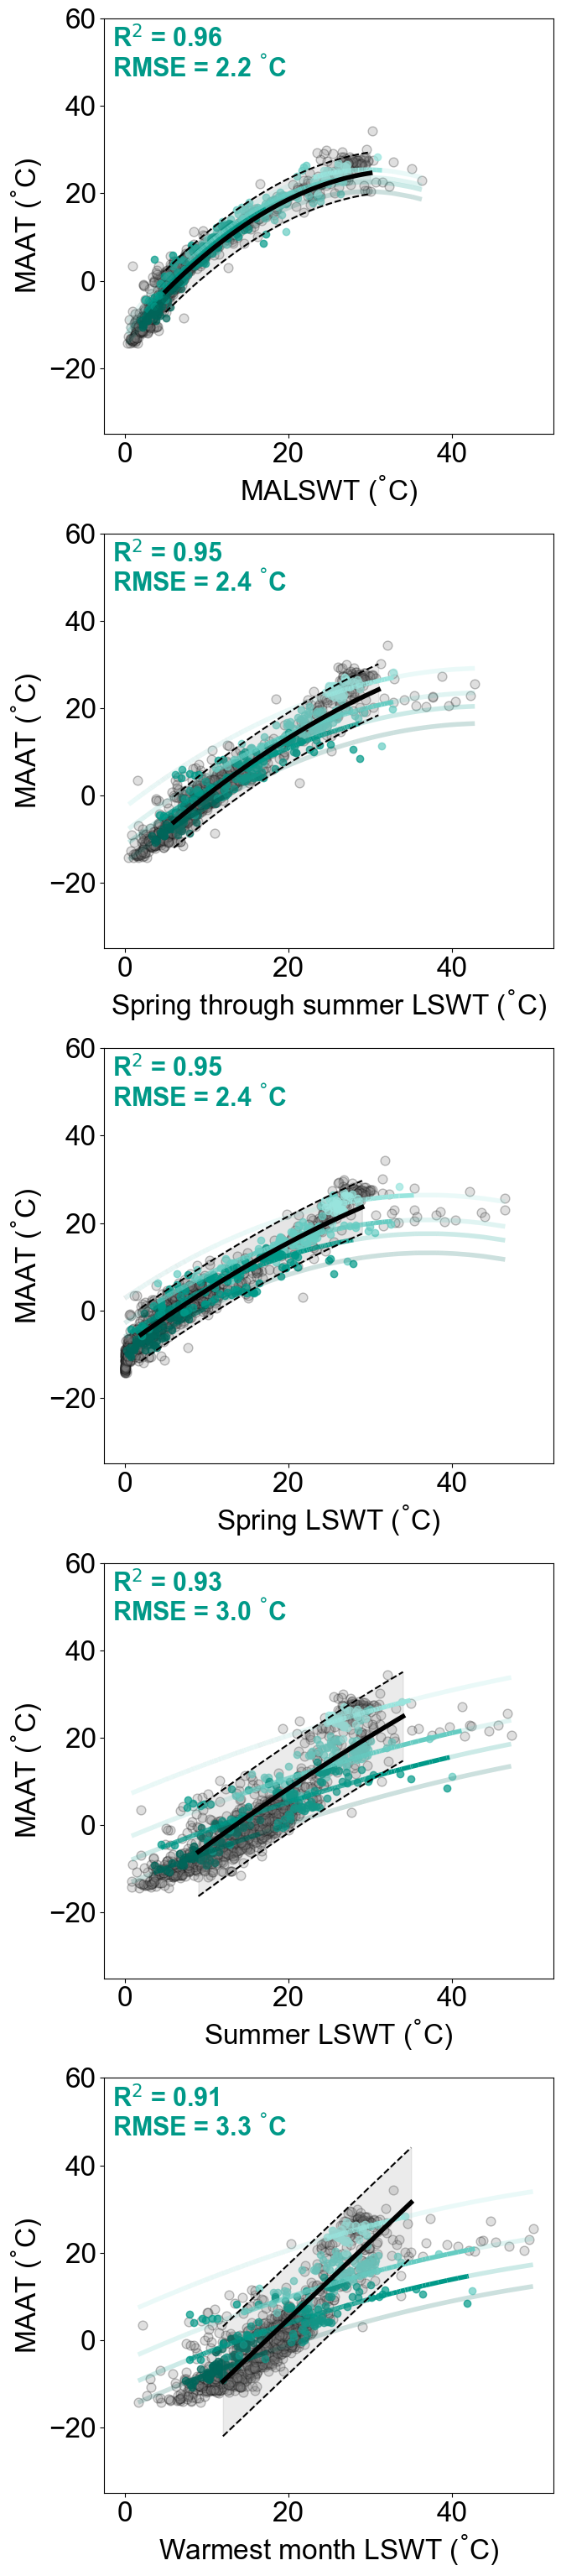

In [12]:
# Define the functions for the different seasons
def f4_ann(lat, elev, x):
    return (-0.0403) * np.power(x, 2) + (2.3890 * x) - 0.0767 * lat - 0.7038 * elev - 8.8227

def f4_ao(lat, elev, x):
    return (-0.0162) * np.power(x, 2) + (1.4369 * x) - 0.2282 * lat - 1.5486 * elev + 0.496

def f4_amj(lat, elev, x):
    return (-0.0172) * np.power(x, 2) + (1.2746 * x) - 0.2331 * lat - 1.6609 * elev + 6.1134

def f4_jja(lat, elev, x):
    return (-0.0043) * np.power(x, 2) + (0.7775 * x) - 0.3937 * lat - 2.3094 * elev + 12.0188

def f4_warmest(lat, elev, x):
    return (-0.0055) * np.power(x, 2) + (0.8336 * x) - 0.4307 * lat - 2.4042 * elev + 11.8427

# Filter data as before
filtered_df = df[(df['abs_lat'] >= 30) & (df['abs_lat'] <= 45) & 
                 (df['Elevation'] >= 0) & (df['Elevation'] <= 300)]

secondfiltered_df = df[(df['abs_lat'] >= 0) & (df['abs_lat'] <= 20) & 
                       (df['Elevation'] >= 500) & (df['Elevation'] <= 1100)]

thirdfiltered_df = df[(df['abs_lat'] >= 30) & (df['abs_lat'] <= 45) & 
                        (df['Elevation'] >= 4200) & (df['Elevation'] <= 5200)]

fourthfiltered_df = df[(df['abs_lat'] >= 45) & (df['abs_lat'] <= 60) & 
                        (df['Elevation'] >= -200) & (df['Elevation'] <= 100)]

# Combine all filtered dataframes
combined_filtered_df = pd.concat([filtered_df, secondfiltered_df, thirdfiltered_df, fourthfiltered_df])

# Remove the combined filtered points from the original df to get remaining points
remaining_df = df[~df.index.isin(combined_filtered_df.index)]

# Function to plot line with opacity within the relevant range and lower opacity elsewhere
def plot_with_opacity(ax, x, y_pred, filtered_df, lswt_col, color):
    min_x = filtered_df[lswt_col].min()
    max_x = filtered_df[lswt_col].max()

    # Create segments for the entire line
    points = np.array([x, y_pred]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Mask for the highlight (opaque) region
    highlight_mask = (x >= min_x) & (x <= max_x)
    highlight_segments = segments[highlight_mask[:-1]]
    
    # Mask for the lower-opacity region
    base_mask = ~highlight_mask
    base_segments = segments[base_mask[:-1]]
    
    # Line within the data range (opaque)
    lc_highlight = LineCollection(highlight_segments, colors=color, linewidths=4, alpha=1)
    ax.add_collection(lc_highlight)
    
    # Line outside the data range (lower opacity)
    lc_base = LineCollection(base_segments, colors=color, linewidths=4, alpha=0.2)
    ax.add_collection(lc_base)

# Function to plot scatter, seasonal model lines, and HS functions
def plot_season(ax, lswt_col, season_func, hs_plot_func=None):
    sorted_df = df.sort_values(by=lswt_col)
        
    # Scatter plots
    ax.scatter(remaining_df[lswt_col], remaining_df['tas_ann_avg'], s = 60, marker = 'o',  color = 'gray', edgecolor = 'k', alpha=0.25)
    ax.scatter(filtered_df[lswt_col], filtered_df['tas_ann_avg'], color='#66CCC2', alpha=0.7)
    ax.scatter(secondfiltered_df[lswt_col], secondfiltered_df['tas_ann_avg'], color='#99E5DE', alpha=0.7) #lightest
    ax.scatter(thirdfiltered_df[lswt_col], thirdfiltered_df['tas_ann_avg'], color='#00665A', alpha=0.7)
    ax.scatter(fourthfiltered_df[lswt_col], fourthfiltered_df['tas_ann_avg'], color='#009988', alpha=0.7)
    
    # Calculate predictions using the correct function for the season
    y_pred = season_func(37.5, 0.15, sorted_df[lswt_col])
    y_pred_low = season_func(10, 0.6, sorted_df[lswt_col])
    y_pred_tibet = season_func(37.5, 4.7, sorted_df[lswt_col])
    y_pred_4 = season_func(52.5, -0.05, sorted_df[lswt_col])
    
    # Plot lines
    plot_with_opacity(ax, sorted_df[lswt_col], y_pred, filtered_df, lswt_col, color='#66CCC2')
    plot_with_opacity(ax, sorted_df[lswt_col], y_pred_low, secondfiltered_df, lswt_col, color='#99E5DE')
    plot_with_opacity(ax, sorted_df[lswt_col], y_pred_tibet, thirdfiltered_df, lswt_col, color='#00665A')
    plot_with_opacity(ax, sorted_df[lswt_col], y_pred_4, fourthfiltered_df, lswt_col, color='#009988')
    
    # Plot the HS function if available
    if hs_plot_func:
        ax, r2, rmse_val = hs_plot_func(ax)

plt.rcParams['font.size'] = 50
plt.rcParams['font.family'] = 'Arial'
  
# Set up the subplots
fig, axs = plt.subplots(5,1, figsize = (8, 32), sharex=True, sharey=True)

# Define the seasons and their associated functions
seasons = {
    'MALSWT': ('lswt_ann_avg', f4_ann),
    'Spring through summer LSWT': ('lswt_ao_avg', f4_ao),
    'Spring LSWT': ('lswt_amj_avg', f4_amj),
    'Summer LSWT': ('lswt_jja_avg', f4_jja),
    'Warmest month LSWT': ('lswt_warmest_avg', f4_warmest)
}

# Map seasons to their respective HS plotting functions
hs_functions = {
    'MALSWT': plot_hs_ann,
    'Spring through summer LSWT': plot_hs_AO,
    'Spring LSWT': plot_hs_AMJ,
    'Summer LSWT': plot_hs_JJA,
    'Warmest month LSWT': plot_hs_Warmest
}

green = '#009988'
r2_ann = plot_bestfit_TF4(axs[0], 'lswt_ann_avg', '')[0]
r2_ao = plot_bestfit_TF4(axs[1], 'lswt_ao_avg', '')[0]
r2_amj = plot_bestfit_TF4(axs[2], 'lswt_amj_avg', '')[0]
r2_jja = plot_bestfit_TF4(axs[3], 'lswt_jja_avg', '')[0]
r2_warmest = plot_bestfit_TF4(axs[4], 'lswt_warmest_avg', '')[0]

rmse_ann = plot_bestfit_TF4(axs[1], 'lswt_ann_avg', '')[1]
rmse_ao = plot_bestfit_TF4(axs[1], 'lswt_ao_avg', '')[1]
rmse_amj = plot_bestfit_TF4(axs[2], 'lswt_amj_avg', '')[1]
rmse_jja = plot_bestfit_TF4(axs[3], 'lswt_jja_avg', '')[1]
rmse_warmest = plot_bestfit_TF4(axs[4], 'lswt_warmest_avg', '')[1]


fs = 22
axs[0].annotate(f'R$^2$ = {r2_ann:.2f}', (0.018, 0.93), xycoords = 'axes fraction', color = green, fontsize = fs, fontweight='bold')
axs[1].annotate(f'R$^2$ = {r2_ao:.2f}', (0.018,  0.93), xycoords = 'axes fraction', color = green, fontsize = fs, fontweight='bold')
axs[2].annotate(f'R$^2$ = {r2_amj:.2f}', (0.018, 0.93), xycoords = 'axes fraction', color = green, fontsize = fs, fontweight='bold')
axs[3].annotate(f'R$^2$ = {r2_jja:.2f}', (0.018,  0.93), xycoords = 'axes fraction', color = green, fontsize = fs, fontweight='bold')
axs[4].annotate(f'R$^2$ = {r2_warmest:.2f}', (0.018, 0.93), xycoords = 'axes fraction', color = green, fontsize = fs, fontweight='bold')

axs[0].annotate(f'RMSE = {rmse_ann:.1f} $^\degree$C', (0.018, 0.86), xycoords='axes fraction', color= green,fontsize = fs, fontweight='bold')
axs[1].annotate(f'RMSE = {rmse_ao:.1f} $^\degree$C', (0.018, 0.86), xycoords='axes fraction', color=green, fontsize = fs, fontweight='bold')
axs[2].annotate(f'RMSE = {rmse_amj:.1f} $^\degree$C', (0.018, 0.86), xycoords='axes fraction',  color=green, fontsize = fs, fontweight='bold')
axs[3].annotate(f'RMSE = {rmse_jja:.1f} $^\degree$C', (0.018, 0.86), xycoords='axes fraction', color=green, fontsize = fs, fontweight='bold')
axs[4].annotate(f'RMSE = {rmse_warmest:.1f} $^\degree$C', (0.018, 0.86), xycoords='axes fraction', color=green, fontsize = fs, fontweight='bold')

# Iterate through seasons and plot each one, including HS functions if available
for i, (season, (lswt_col, season_func)) in enumerate(seasons.items()):
    ax = axs[i]
    
    # Plot the main season first
    plot_season(ax, lswt_col, season_func)
    
    # Add the HS function after the season plot
    hs_func = hs_functions.get(season)
    if hs_func:
        hs_func(ax)
    
    ax.set_ylim(-35, 60)
    ax.set_xlabel(f"{season} ($^\degree$C)", fontsize=24)
    ax.set_ylabel("MAAT ($^\degree$C)", fontsize=24)

# Adjust tick parameters and show plot
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.xaxis.set_tick_params(labelbottom=True)  # Ensure x-tick labels are enabled


plt.tight_layout()
plt.subplots_adjust(hspace=0.24)  # Adjust the vertical space between subplots
# plt.savefig('TF4revised_fig4.png', dpi=300, bbox_inches='tight')

plt.show()
